In [1]:
%matplotlib widget
import torch
import os
import copy
import subprocess
import shlex

os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

from sphMath.sampling import buildDomainDescription
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.integration import getIntegrator
from sphMath.util import volumeToSupport
from sphMath.boundary import sampleDomainSDF
from sphMath.kernels import getKernelEnum
from sphMath.sdf import getSDF, sdfFunctions, operatorDict, sampleSDF
from sphMath.regions import buildRegion, filterRegion, plotRegions
from sphMath.modules.timestep import computeTimestep
# from sphMath.schemes.weaklyCompressible import updateBodyParticles, initializeWeaklyCompressibleSimulation
from sphMath.schemes.initializers import initializeSimulation, updateBodyParticles
from sphMath.schemes.deltaSPH import deltaPlusSPHScheme, DeltaPlusSPHSystem
from torch.profiler import profile,  ProfilerActivity
from sphMath.schema import getSimulationScheme
from sphMath.enums import *

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 256
L = 2
dim = 2
kernel = 'Wendland4'
targetNeighbors = n_h_to_nH(4,dim)
CFL = 0.3

integrationScheme = 'RK2'
dx = L / nx
band = 5

aspect = 1/1

domain = buildDomainDescription(l = L + dx * (band) * 2, dim = dim, periodic = True, device = device, dtype = dtype)
domain.min = torch.tensor([-L/2/ aspect - dx*band, -L/2 - dx * band], device = device, dtype = dtype)
domain.max = torch.tensor([L/2/ aspect + dx*band, L/2 + dx * band], device = device, dtype = dtype)

interiorDomain = buildDomainDescription(l = L, dim = dim, periodic = True, device = device, dtype = dtype)
interiorDomain.min = torch.tensor([-L/2 / aspect, -L/2], device = device, dtype = dtype)
interiorDomain.max = torch.tensor([L/2/ aspect, L/2], device = device, dtype = dtype)


# interiorDomain = buildDomainDescription(l = L, dim = dim, periodic = False, device = device, dtype = dtype)
wrappedKernel = kernel
integrationScheme = getIntegrator(integrationScheme)

config = {
    'domain': domain,
    'kernel': wrappedKernel,
    'targetNeighbors': targetNeighbors,
    'verletScale': 1.4,
    'shifting': {'scheme': 'delta', 'freeSurface': True},
    'surfaceDetection': {'active': True},
    'pressure':{'term': 'Antuono'},
    'fluid': {'rho0': 1, 'c_s': 20},    
    'gravity': {'active': False, 'magnitude': 10, 'mode': 'directional', 'direction': torch.tensor([0, -1], device = device, dtype = dtype)},
    'particle': {'nx': nx, 'dx': dx, 'targetNeighbors': targetNeighbors, 'band': band, 'support': volumeToSupport((L/nx)**dim, targetNeighbors, dim)},
    'timestep':{'CFL': CFL, 'dt': 1e-3, 'maxDt': 1e-2, 'minDt': 1e-6}
}

r1: 0.8333, r2: 1, eta: 0.8333
omega1: 0.1963, omega2: -0.1963, mu: -1
nu: 0.5, nu_sph: 0.0651
Taylor Number: 1320.623934256696


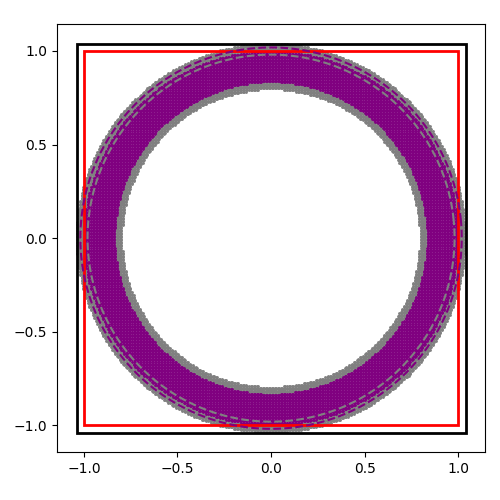

In [29]:
fluid_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('circle')['function'](x, torch.tensor(L/2/aspect).to(points.device)), torch.tensor([0,0]).to(points.device)), invert = False)


def domainSDF(p, domain, invert = False):
    center = (domain.min + domain.max) / 2
    halfExtents = (domain.max - domain.min) / 2
    d = torch.abs(p - center) - halfExtents
    return (1 if invert else -1) * (torch.linalg.norm(d.clamp(min = 0), dim = -1) + torch.max(d, dim = -1)[0].clamp(max=0))


# domain_sdf = lambda x: domainSDF(x, interiorDomain, invert = False)

# inner_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('circle')['function'](x, torch.tensor(L/4).to(points.device)), torch.tensor([0,0]).to(points.device)), invert = False)
# outer_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('circle')['function'](x, torch.tensor(L/2).to(points.device)), torch.tensor([0,0]).to(points.device)), invert = True)

import numpy as np
r1 = 5/6 * L/2
r2 = L/2
eta = r1/r2

omega1 = np.pi/16
omega2 = -np.pi/16
mu = omega2 / omega1

nu = 0.5
nu_sph = nu * config['fluid']['c_s'] * config['particle']['support'] / (2 * domain.dim + 2)*5/4

Ta = (4 * omega1**2 * r1**2) / nu_sph**2 * ((1 - mu) * (1 - mu / eta**2))/(1 - eta**2)**2
print(f'r1: {r1:.4g}, r2: {r2:.4g}, eta: {eta:.4g}')
print(f'omega1: {omega1:.4g}, omega2: {omega2:.4g}, mu: {mu:.4g}')
print(f'nu: {nu:.4g}, nu_sph: {nu_sph:.4g}')
print(f'Taylor Number: {Ta}')


circleInner = operatorDict['translate'](lambda p: getSDF('circle')['function'](p, torch.tensor(r1).to(p.device)), torch.tensor([0,0]).to(device))
circleOuter = operatorDict['translate'](lambda p: getSDF('circle')['function'](p, torch.tensor(r2).to(p.device)), torch.tensor([0,0]).to(device))
circleShell = operatorDict['translate'](lambda p: getSDF('circle')['function'](p, torch.tensor(r2 + dx * band).to(p.device)), torch.tensor([0,0]).to(device))
circleInnerShell = operatorDict['translate'](lambda p: getSDF('circle')['function'](p, torch.tensor(r1 - dx*band).to(p.device)), torch.tensor([0,0]).to(device))

fluidRegion = operatorDict['union'](circleInnerShell, circleShell)



config['particle']['shortEdge'] = False
regions = []
from sphMath.sampling import ParticleSet

regions.append(buildRegion(sdf = lambda points: sampleSDF(points, circleInner, False), config = config, type = 'boundary', kind = 'driven'))
cutAway = +circleInnerShell(regions[-1]['particles'].positions)
regions[-1]['particles'] = ParticleSet(
    positions = regions[-1]['particles'].positions[cutAway > 0],
    supports = regions[-1]['particles'].supports[cutAway > 0],
    densities = regions[-1]['particles'].densities[cutAway > 0],
    masses = regions[-1]['particles'].masses[cutAway > 0],
)


regions.append(buildRegion(sdf = lambda points: sampleSDF(points, circleOuter, True), config = config, type = 'boundary', kind = 'driven'))
cutAway = -circleShell(regions[-1]['particles'].positions)
regions[-1]['particles'] = ParticleSet(
    positions = regions[-1]['particles'].positions[cutAway > 0],
    supports = regions[-1]['particles'].supports[cutAway > 0],
    densities = regions[-1]['particles'].densities[cutAway > 0],
    masses = regions[-1]['particles'].masses[cutAway > 0],
)

# regions.append(buildRegion(sdf = outer_sdf, config = config, type = 'boundary', kind = 'constant'))
# regions.append(buildRegion(sdf = triangle_sdf, config = config, type = 'boundary', kind = 'zero'))
regions.append(buildRegion(sdf = lambda points: sampleSDF(points, fluidRegion, False), config = config, type = 'fluid'))
# regions.append(buildRegion(sdf = inlet_sdf, config = config, type = 'inlet', dirichletValues={'densities': config['fluid']['rho0'], 'velocities': torch.tensor([1,0], device = device, dtype = dtype)}, updateValues = {'densities': 0, 'velocities': torch.tensor([0,0], device = device, dtype = dtype)}))

# regions.append(buildRegion(sdf = outlet_sdf, config = config, type = 'outlet'))
# regions.append(buildRegion(sdf = outletBuffer_sdf, config = config, type = 'buffer', bufferValues = ['densities', 'velocities', 'pressures']))

# regions.append(buildRegion(sdf = box_sdf, config = config, type = 'dirichlet', dirichletValues={'densities': 2.0, 'velocities': torch.tensor([1,2], device = device, dtype = dtype), 'pressures': lambda x: torch.where(x[:,0] > 0, 0.0, 1.0)}, updateValues = {'densities': 2.0}))


for region in regions:
    region = filterRegion(region, regions)


fig, axis = plt.subplots(1, 1, figsize=(5, 5), squeeze=False)
    
plotRegions(regions, axis[0,0], plotFluid = True, plotParticles = True)
axis[0,0].set_aspect('equal', adjustable='box')

rectangle = plt.Rectangle((domain.min[0].cpu().numpy(), domain.min[1].cpu().numpy()), domain.max[0].cpu().numpy() - domain.min[0].cpu().numpy(), domain.max[1].cpu().numpy() - domain.min[1].cpu().numpy(), fill=False, color='black', lw=2)
axis[0,0].add_patch(rectangle)

rectangleInterior = plt.Rectangle((interiorDomain.min[0].cpu().numpy(), interiorDomain.min[1].cpu().numpy()), interiorDomain.max[0].cpu().numpy() - interiorDomain.min[0].cpu().numpy(), interiorDomain.max[1].cpu().numpy() - interiorDomain.min[1].cpu().numpy(), fill=False, color='red', lw=2)
axis[0,0].add_patch(rectangleInterior)

fig.tight_layout()





In [ ]:
particleState, config, rigidBodies = initializeSimulation(scheme, config, regions)

rigidBodies[0].angularVelocity = omega1
rigidBodies[1].angularVelocity = omega2
particleState.densities[:] = config['fluid']['rho0']

particles = copy.deepcopy(particleState)
particleSystem = DeltaPlusSPHSystem(domain, None, 0., copy.deepcopy(particleState), 'momentum', None, rigidBodies = rigidBodies, regions = config['regions'], config = config)


for rigidBody in rigidBodies:
    particleSystem.systemState = updateBodyParticles(particleSystem.systemState, rigidBody)
    
config['timestep'] = {'CFL': CFL, 'dt': 1e-3, 'maxDt': 1e-2, 'minDt': 1e-6}
dt = computeTimestep(scheme, 1e-2, particleSystem.systemState, config, None)
print(dt)
config['timestep']['dt'] = dt

kineticEnergy = 0.5 * particleState.densities * (particleState.velocities ** 2).sum(1)

t = 0
E_k0 = 0.5 * particleState.masses * torch.linalg.norm(particleState.velocities, dim = -1)**2
E_k = 0.5 * particleState.masses * torch.linalg.norm(particleState.velocities, dim = -1)**2

rhoMin = particleState.densities.min().detach().cpu().item() / config['fluid']['rho0']
rhoMean = particleState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
rhoMax = particleState.densities.max().detach().cpu().item() / config['fluid']['rho0']


initialVelocity = particleState.velocities.clone()
initialDensities = particleState.densities.clone()

initialKineticEnergy = 0.5 * particleState.masses / config['fluid']['rho0'] * particleState.densities * torch.linalg.norm(initialVelocity, dim = -1)**2

t = 0

[0 1]
[SPH] - Adaptive Timestep Update
	CFL: 0.3, maxDt: 0.01, minDt: 1e-06
	Diffusion: 0.01, deltaSPH_inviscid
	Fluid: 20, 0.03125, 2.171239
	Viscosity: 0.07196351885795593, Acoustic: 0.00021589055540971458, Acceleration: 0.009999999776482582
tensor(0.0002, device='cuda:0')


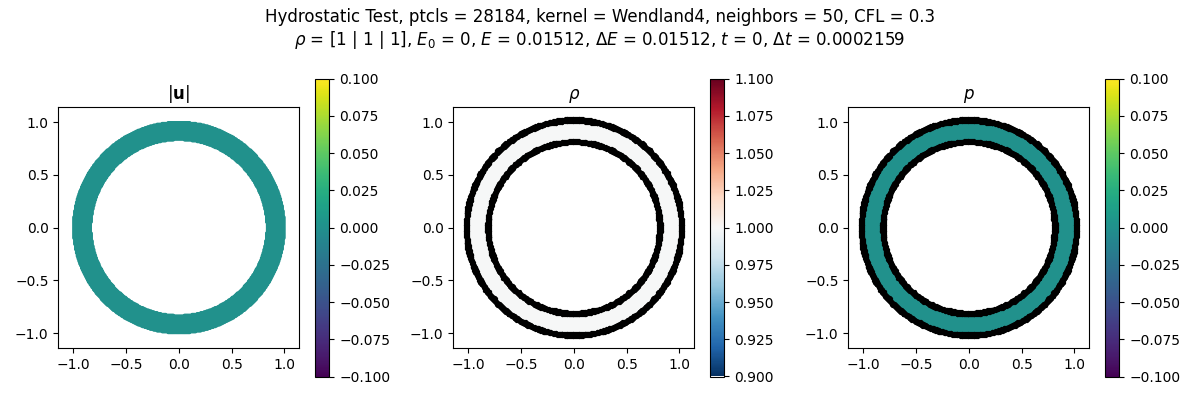

In [31]:
kineticEnergy = 0.5 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.velocities, dim = -1)**2

fig, axis = plt.subplots(1, 3, figsize = (12, 4), squeeze=False)

markerSize = 2
vxPlot = visualizeParticles(fig, axis[0,0], 
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.velocities, 
            which = 'fluid',
            mapping = 'L2',
            cmap = 'viridis',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
# axis[0,0].set_title('Density')

vyPlot = visualizeParticles(fig, axis[0,1],
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.densities, 
            which = 'fluid',
            # operation = 'curl',
            mapping = '.x',
            cmap = 'RdBu_r',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize)

uidPlot = visualizeParticles(fig, axis[0,2],
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.pressures, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
axis[0,0].set_title(r'$|\mathbf{u}|$')
axis[0,1].set_title(r'$\rho$')
axis[0,2].set_title(r'$p$')


totalInitialEnergy = (initialKineticEnergy).sum().detach().cpu().item()
totalEnergy = (kineticEnergy).sum().detach().cpu().item()

fig.suptitle(f'Hydrostatic Test, ptcls = {particleState.positions.shape[0]}, kernel = {kernel}, neighbors = {targetNeighbors:.2g}, CFL = {CFL}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {t:.4g}, $\Delta t$ = {dt:.4g}')

fig.tight_layout()

In [32]:
imagePrefix = './images/Taylor_Couette/'
os.makedirs(imagePrefix, exist_ok = True)

fig.savefig(f'{imagePrefix}frame_{0:05d}.png', dpi = 100)

config['diffusion'] = {'alpha': 0.5}

In [33]:
particles = copy.deepcopy(particleState)
particleSystem = DeltaPlusSPHSystem(domain, None, 0., copy.deepcopy(particleState), 'momentum', None, rigidBodies = rigidBodies, regions = config['regions'], config = config)

t = 0
timeLimit = 10
timesteps = int(timeLimit / dt)
plotInterval = 50

for i in (tq:=tqdm(range(timesteps))):
    particleSystem, currentState, updates = integrationScheme.function(particleSystem, dt, deltaPlusSPHScheme, config, priorStep = particleSystem.priorStep, verbose = False)
    
    particleSystem.systemState.velocities = particleSystem.systemState.velocities * 0.99

    if i % plotInterval == plotInterval - 1 or i == timesteps - 1:

        rhoMin = particleSystem.systemState.densities.min().detach().cpu().item() / config['fluid']['rho0']
        rhoMean = particleSystem.systemState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
        rhoMax = particleSystem.systemState.densities.max().detach().cpu().item() / config['fluid']['rho0']

        kineticEnergy = 0.5 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.velocities, dim = -1)**2
        totalInitialEnergy = (initialKineticEnergy).sum().detach().cpu().item()
        totalEnergy = (kineticEnergy).sum().detach().cpu().item()

        fig.suptitle(f'Kolmogorov Flow, ptcls = {particleState.positions.shape[0]}, kernel = {kernel}, neighbors = {targetNeighbors:.2g}, CFL = {CFL}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {particleSystem.t:.4g}, $\Delta t$ = {dt:.4g}')

        updatePlot(vxPlot, particleSystem.systemState, particleSystem.systemState.velocities)
        updatePlot(vyPlot, particleSystem.systemState, particleSystem.systemState.densities)
        updatePlot(uidPlot, particleSystem.systemState, particleSystem.systemState.pressures)

        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(f'{imagePrefix}frame_{i:05d}.png', dpi = 100)
    # break
    # if i > 90:
        # break
    

  0%|          | 0/46319 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
output = 'timestamp'
scale = 1280

command = '/usr/bin/ffmpeg -loglevel warning -hide_banner -y -framerate 50 -f image2 -pattern_type glob -i '+ imagePrefix + '/frame_*.png -c:v libx264 -b:v 20M -r 50 ' + imagePrefix + '/output.mp4'
commandB = f'/usr/bin/ffmpeg -loglevel warning -hide_banner -y -i {imagePrefix}/output.mp4 -vf "fps=50,scale={scale}:-1:flags=lanczos,palettegen" {imagePrefix}/palette.png'
commandC = f'/usr/bin/ffmpeg -loglevel warning -hide_banner -y -i {imagePrefix}/output.mp4 -i {imagePrefix}/palette.png -filter_complex "fps=50,scale={scale}:-1:flags=lanczos[x];[x][1:v]paletteuse" {imagePrefix}/output.gif'

print('Creating video from  frames (frame count: {})'.format(len(os.listdir(imagePrefix))))
subprocess.run(shlex.split(command))
print('Creating gif palette')
subprocess.run(shlex.split(commandB))
print('Creating gif')
subprocess.run(shlex.split(commandC))
print('Done')


Creating video from  frames (frame count: 141)
Creating gif palette
Creating gif
Done


In [ ]:
print(command)
print(commandB)
print(commandC)

/usr/bin/ffmpeg -loglevel warning -hide_banner -y -framerate 50 -f image2 -pattern_type glob -i ./images/kolmogorov//frame_*.png -c:v libx264 -b:v 20M -r 50 ./images/kolmogorov//output.mp4
/usr/bin/ffmpeg -loglevel warning -hide_banner -y -i ./images/kolmogorov//output.mp4 -vf "fps=50,scale=1280:-1:flags=lanczos,palettegen" ./images/kolmogorov//palette.png
/usr/bin/ffmpeg -loglevel warning -hide_banner -y -i ./images/kolmogorov//output.mp4 -i ./images/kolmogorov//palette.png -filter_complex "fps=50,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse" ./images/kolmogorov//output.gif
